In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from mpc.track.src import simple_track_generator, track_functions
from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx

from torch.func import jacfwd, vmap

import utils

import cvxpy as cp
#from cvxpylayers.torch import CvxpyLayer

import torch.autograd.functional as F

from mpc import casadi_control

import scipy.linalg

from tqdm import tqdm

(CVXPY) Aug 13 06:05:22 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 13 06:05:22 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
from casadi import *

class CasadiControl():
    def __init__(self, track_coordinates, params):
        super().__init__()

        params = params.numpy()
        
        # states: sigma, d, phi, v (4) + sigma_0, sigma_diff (2) + d_pen (1) + v_ub (1) + ac_ub (1)
        self.n_state = 4+2+1+1+1
        print(self.n_state)          # here add amount of states plus amount of exact penalty terms
        # control: a, delta
        self.n_ctrl = 2

        self.track_coordinates = track_coordinates

        # everything to calculate curvature
        self.track_sigma = self.track_coordinates[2,:]
        self.track_curv = self.track_coordinates[4,:]

        self.track_curv_shift = torch.empty(self.track_curv.size())
        self.track_curv_shift[1:] = self.track_curv[0:-1]
        self.track_curv_shift[0] = self.track_curv[-1]
        self.track_curv_diff = self.track_curv - self.track_curv_shift

        self.mask = torch.where(torch.absolute(self.track_curv_diff) < 0.1, False, True)
        self.sigma_f = self.track_sigma[self.mask]
        self.curv_f = self.track_curv_diff[self.mask]

        self.params = params

        self.l_r = params[0]
        self.l_f = params[1]
        
        self.track_width = params[2]
        
        self.delta_threshold_rad = np.pi
        self.dt = params[3]

        self.smooth_curve = params[4]
        
        self.v_max = params[5]
        
        self.delta_max = params[6]
        
        self.a_max = params[7]
        
        self.mpc_T = int(params[8])
        
    def sigmoid(self, x):
        return (tanh(x/2)+1.)/2

    def curv_casadi(self, sigma):
        
        num_sf = self.sigma_f.size()
        num_s = sigma.size()

        sigma_f_mat = self.sigma_f.repeat(num_s[1],1)
   
        sigma_f_mat_np = sigma_f_mat.numpy()
        sigma_f_np = self.sigma_f.numpy()
        curv_f_np = self.curv_f.numpy()

        sigma_shifted = reshape(sigma,num_s[1],1)- sigma_f_mat_np
        curv_unscaled = self.sigmoid(self.smooth_curve*sigma_shifted)
        curv = reshape((curv_unscaled@(curv_f_np.reshape(-1,1))),1,num_s[1])

        return curv
    
    
    def mpc_casadi(self,q,p,x0_np,dx,du):
        mpc_T = self.mpc_T

        x_sym = SX.sym('x_sym',dx,mpc_T+1)
        u_sym = SX.sym('u_sym',du,mpc_T)

        beta = np.arctan(l_r/(l_r+l_f)*np.tan(u_sym[1,0:mpc_T]))

        dyn1 = horzcat(
            (x_sym[0,0] - x0_np[0]), 
            (x_sym[0,1:mpc_T+1] - x_sym[0,0:mpc_T] - dt*(x_sym[3,0:mpc_T]*(np.cos(x_sym[2,0:mpc_T]+beta)/(1.-self.curv_casadi(x_sym[0,0:mpc_T])*x_sym[1,0:mpc_T])))))

        dyn2 = horzcat(
            (x_sym[1,0] - x0_np[1]), 
            (x_sym[1,1:mpc_T+1] - x_sym[1,0:mpc_T] - dt*(x_sym[3,0:mpc_T]*np.sin(x_sym[2,0:mpc_T]+beta))))

        dyn3 = horzcat(
            (x_sym[2,0] - x0_np[2]), 
            (x_sym[2,1:mpc_T+1] - x_sym[2,0:mpc_T] - dt*(x_sym[3,0:mpc_T]*(1/l_f)*np.sin(beta)-self.curv_casadi(x_sym[0,0:mpc_T])*x_sym[3,0:mpc_T]*(np.cos(x_sym[2,0:mpc_T]+beta)/(1-self.curv_casadi(x_sym[0,0:mpc_T])*x_sym[1,0:mpc_T])))))

        dyn4 = horzcat(
            (x_sym[3,0] - x0_np[3]), 
            (x_sym[3,1:mpc_T+1] - x_sym[3,0:mpc_T] - dt*(u_sym[0,0:mpc_T])))

        feat = vertcat(x_sym[0,0:mpc_T]-x0_np[0],x_sym[1:,0:mpc_T],u_sym[:,0:mpc_T])

        q_sym = SX.sym('q_sym',dx+du,mpc_T)
        p_sym = SX.sym('q_sym',dx+du,mpc_T)
        Q_sym = diag(q_sym)

        l = sum2(sum1(0.5*q_sym*feat*feat + p_sym*feat))
        dl = substitute(substitute(l,q_sym,q),p_sym,p)

        const = vertcat(
                transpose(dyn1),
                transpose(dyn2),
                transpose(dyn3),
                transpose(dyn4),
                transpose(u_sym[0,0:mpc_T]),
                transpose(u_sym[1,0:mpc_T]),
                transpose(x_sym[1,0:mpc_T+1]),
                transpose(x_sym[3,0:mpc_T+1]))

        lbg = np.r_[np.zeros(mpc_T+1),
                    np.zeros(mpc_T+1),
                    np.zeros(mpc_T+1),
                    np.zeros(mpc_T+1),
                    -self.a_max*np.ones(mpc_T),
                    -self.delta_max*np.ones(mpc_T),
                    -0.35*self.track_width*np.ones(mpc_T+1),
                    -0.1*np.ones(mpc_T+1)]

        ubg = np.r_[np.zeros(mpc_T+1),
                    np.zeros(mpc_T+1),
                    np.zeros(mpc_T+1),
                    np.zeros(mpc_T+1),
                    self.a_max*np.ones(mpc_T),
                    self.delta_max*np.ones(mpc_T),
                    0.35*self.track_width*np.ones(mpc_T+1),
                    self.v_max*np.ones(mpc_T+1)]


        lbx = -np.inf * np.ones(dx*(mpc_T+1)+du*mpc_T)
        ubx = np.inf * np.ones(dx*(mpc_T+1)+du*mpc_T)

        x = vertcat(reshape(x_sym[:,0:mpc_T+1],(dx*(mpc_T+1),1)),
                    reshape(u_sym[:,0:mpc_T],(du*mpc_T,1)))

        options = {
                    'verbose': False,
                    'ipopt.print_level': 0,
                    'print_time': 0,
                    'ipopt.tol': 1e-4,
                    'ipopt.max_iter': 4000,
                    'ipopt.hessian_approximation': 'limited-memory'
                }

        nlp = {'x':x,'f':dl, 'g':const}
        solver = nlpsol('solver','ipopt', nlp, options)

        solver_input = {}
        solver_input['lbx'] = lbx
        solver_input['ubx'] = ubx
        solver_input['lbg'] = lbg
        solver_input['ubg'] = ubg

        solver_output = solver(**solver_input)

        sol = solver_output['x']

        sol_evalf = np.squeeze(evalf(sol))
        u = sol_evalf[-du*mpc_T:].reshape(-1,du)
        x = sol_evalf[:-du*mpc_T].reshape(-1,dx)

        return x, u

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, mpc_H, mpc_T, O, K):
        super(SimpleNN, self).__init__()
        input_size = 3 + mpc_H
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, mpc_T*O)
        self.activation = nn.ReLU()
        self.output_activation = nn.Tanh()
        self.K = K
        self.O = O
        self.mpc_T = mpc_T

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = self.output_activation(x) * self.K
        x = x.reshape(self.mpc_T, -1, self.O)
        return x

In [4]:
def sample_init(BS, dyn, sn=None):
    
    # If sn!=None, we makesure that we always sample the same set of initial states
    # We need that for validation to understand if our model is improving or not
    
    gen=None
    if sn != None:
        gen = torch.Generator()
        gen.manual_seed(sn)
    
    di = 1000
    sigma_sample = torch.randint(int(0.5*di), int(6.0*di), (BS,1), generator=gen)/di
    d_sample = torch.randint(int(-.15*di), int(.15*di), (BS,1), generator=gen)/di
    phi_sample = torch.randint(int(-0.08*di), int(0.08*di), (BS,1), generator=gen)/di
    v_sample = torch.randint(0, int(.22*di), (BS,1), generator=gen)/di
    
    sigma_diff_sample = torch.zeros((BS,1))
    
    d_pen = dyn.penalty_d(d_sample)
    v_pen = dyn.penalty_v(v_sample)
    
    x_init_sample = torch.hstack((
        sigma_sample, d_sample, phi_sample, v_sample, 
        sigma_sample, sigma_diff_sample, d_pen, v_pen))   
    
    return x_init_sample


def sample_init_traj(BS, dyn, traj, num_patches, patch, sn=None):
    
    # If sn!=None, we makesure that we always sample the same set of initial states
    # We need that for validation to understand if our model is improving or not
    
    gen=None
    if sn != None:
        gen = torch.Generator()
        gen.manual_seed(sn)
    
    di = 1000
    
    # The idea is to take the trajectory and divide it into num_patches patches.
    # The variable patch indicates in which patch we currently are. 
    
    # we also need to adapt the batch size such that no 
    #print('traj:',traj)
    
    traj_steps = np.shape(traj)
    #print('traj_steps:',traj_steps)
    patch_steps = np.floor(traj_steps[0]/num_patches)
    
    # in this step we randomly 
    traj_ind_sample = torch.randint(0,int(patch_steps*patch),(BS,1), generator=gen)
    #print('traj_ind_sample:',traj_ind_sample)
    traj_sample = traj[traj_ind_sample.detach().numpy().flatten(),:]
    #print('traj_sample:',traj_sample)
    
    # now we keep sigma as it is and sample d, phi, and v in a small "tube" around the traj points
    
    # Note that we clamp the sampled d and v values to stay in their constraints. Sampling constraint violating 
    # states would not make sense. 
    
    d_sample = torch.clamp(torch.from_numpy(traj_sample[:,1].reshape(-1,1))+torch.randint(int(-.08*di), int(.08*di), (BS,1), generator=gen)/di,-0.24,0.24)
    phi_sample = torch.from_numpy(traj_sample[:,2].reshape(-1,1))+torch.randint(int(-0.02*di), int(0.02*di), (BS,1), generator=gen)/di
    v_sample = torch.clamp(torch.from_numpy(traj_sample[:,3].reshape(-1,1))+torch.randint(int(-0.05*di), int(.05*di), (BS,1), generator=gen)/di,0.0,2.5)
    
    # and this part we can actually keep
    
    sigma_diff_sample = torch.zeros((BS,1))
    
    d_pen = dyn.penalty_d(d_sample)
    v_pen = dyn.penalty_v(v_sample)
    
    x_init_sample = torch.hstack((
        torch.from_numpy(traj_sample[:,0].reshape(-1,1)), d_sample, phi_sample, v_sample, 
        torch.from_numpy(traj_sample[:,0].reshape(-1,1)), sigma_diff_sample, d_pen, v_pen))   
    
    return x_init_sample

def get_curve_hor_from_x(x, track_coord, H_curve):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(H_curve)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

In [5]:
class FrenetKinBicycleDx(nn.Module):
    def __init__(self, track_coordinates, params, dev):
        super().__init__()
        
        self.params = params

        # states: sigma, d, phi, v (4) + sigma_0, sigma_diff (2) + d_pen (1) + v_ub (1)
        self.n_state = 4+2+1+1
        print('Number of states:', self.n_state)
        
        self.n_ctrl = 2 # control: a, delta

        self.track_coordinates = track_coordinates.to(dev)

        # everything to calculate curvature
        self.track_sigma = self.track_coordinates[2,:]
        self.track_curv = self.track_coordinates[4,:]

        self.track_curv_shift = torch.empty(self.track_curv.size()).to(dev)
        self.track_curv_shift[1:] = self.track_curv[0:-1]
        self.track_curv_shift[0] = self.track_curv[-1]
        self.track_curv_diff = self.track_curv - self.track_curv_shift

        self.mask = torch.where(torch.absolute(self.track_curv_diff) < 0.1, False, True)
        self.sigma_f = self.track_sigma[self.mask]
        self.curv_f = self.track_curv_diff[self.mask]
     
        self.l_r = params[0]
        self.l_f = params[1]
        
        self.track_width = params[2]
        
        self.delta_threshold_rad = np.pi
        self.dt = params[3]

        self.smooth_curve = params[4]
        
        self.v_max = params[5]
        
        self.delta_max = params[6]
        
        self.factor_pen = 1000.
                
        
        
    def curv(self, sigma):

        num_sf = self.sigma_f.size()
        num_s = sigma.size()

        sigma_f_mat = self.sigma_f.repeat(num_s[0],1)

        sigma_shifted = sigma.reshape(-1,1) - sigma_f_mat
        curv_unscaled = torch.sigmoid(self.smooth_curve*sigma_shifted)
        curv = (curv_unscaled@(self.curv_f.reshape(-1,1))).type(torch.float)

        return curv.reshape(-1)
    
    
    def penalty_d(self, d):  
        overshoot_pos = (d - 0.35*self.track_width).clamp(min=0)
        overshoot_neg = (-d - 0.35*self.track_width).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_v(self, v):          
        overshoot_pos = (v - self.v_max).clamp(min=0)
        overshoot_neg = (-v + 0.001).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_delta(self, delta):          
        overshoot_pos = (delta - self.delta_max).clamp(min=0)
        overshoot_neg = (-delta - self.delta_max).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def forward(self, state, u):
        squeeze = state.ndimension() == 1
        if squeeze:
            state = state.unsqueeze(0)
            u = u.unsqueeze(0)
        if state.is_cuda and not self.params.is_cuda:
            self.params = self.params.cuda()


        a, delta = torch.unbind(u, dim=1)

        sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)
        
        beta = torch.atan(self.l_r/(self.l_r+self.l_f)*torch.tan(delta))       
        k = self.curv(sigma)

        dsigma = v*(torch.cos(phi+beta)/(1.-k*d))
        dd = v*torch.sin(phi+beta)
        dphi = v/self.l_f*torch.sin(beta)-k*v*(torch.cos(phi+beta)/(1-k*d))       
        
        dv = a      

        sigma = sigma + self.dt * dsigma
        d = d + self.dt * dd
        phi = phi + self.dt * dphi
        v = v + self.dt * dv 
        
        sigma_diff = sigma - sigma_0 
                
        d_pen = self.penalty_d(d)        
        v_ub = self.penalty_v(v)

        state = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub), 1)
        
        return state

In [6]:
def solve_casadi(q_np,p_np,x0_np,dx,du,control):
    
    x_curr_opt, u_curr_opt = control.mpc_casadi(q_np,p_np,x0_np,dx,du)

    sigzero_curr_opt = np.expand_dims(x_curr_opt[[0],0].repeat(mpc_T+1), 1)
    sigsiff_curr_opt = x_curr_opt[:,[0]]-x_curr_opt[0,0]

    x_curr_opt_plus = np.concatenate((
        x_curr_opt,sigzero_curr_opt,sigsiff_curr_opt), axis = 1)

    x_star = x_curr_opt_plus[:-1]
    u_star = u_curr_opt
    
    return x_star, u_star



def q_and_p(mpc_T, q_p_pred, Q_manual, p_manual):
    # Cost order: 
    # [for casadi] sigma_diff, d, phi, v, a, delta
    # [for model]  sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_pen, a, delta
    
    mpc_T, BS, _ = q_p_pred.shape 
    
    e = 1e-8
    
    q = e*torch.ones((mpc_T,BS,10)) + torch.tensor(Q_manual).unsqueeze(1).float()
    p = torch.zeros((mpc_T,BS,10)) + torch.tensor(p_manual).unsqueeze(1).float()

    #sigma_diff
    #q[:,:,5] = q_p_pred[:,:,0].clamp(e)
    p[:,:,5] = p[:,:,5] + q_p_pred[:,:,0]
    
    #d
    #q[:,:,1] = q_p_pred[:,:,1].clamp(e)
    p[:,:,1] = p[:,:,1] + q_p_pred[:,:,1]    
    
    return q, p

In [7]:
# I changed from 100 to 5 to try.
k_curve = 5.

dt = 0.04

mpc_T = 20
mpc_H = 40

l_r = 0.2
l_f = 0.2

v_max = 2.0

delta_max = 0.6

a_max = 1.5

track_density = 300
track_width = 0.5
t_track = 0.3
init_track = [0,0,0]

max_p = 100 

params = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, mpc_T])

In [8]:
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'DEMO_TRACK'

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)

In [9]:
track_function(gen, t_track, init_track)
gen.populatePointsAndArcLength()
gen.centerTrack()
track_coord = torch.from_numpy(np.vstack(
    [gen.xCoords, 
     gen.yCoords, 
     gen.arcLength, 
     gen.tangentAngle, 
     gen.curvature]))

In [10]:
true_dx = FrenetKinBicycleDx(track_coord, params, 'cpu')

Number of states: 8


In [11]:
x0 = torch.tensor([0.0, 0.1, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
u0 = torch.tensor([0.0, 0.0])

In [12]:
dx=4
du=2

In [13]:
BS = 16
u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, BS, 1)#.to(dev)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, BS, 1)#.to(dev)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, BS, 1)#.to(device)
eps=0.01
lqr_iter = 50

grad_method = GradMethods.AUTO_DIFF

In [14]:
model = SimpleNN(mpc_H, mpc_T, 2, max_p)
opt = torch.optim.RMSprop(model.parameters(), lr=0.0005)

In [15]:
control = CasadiControl(track_coord, params)
Q_manual = np.repeat(np.expand_dims(np.array([0, 20, 5, 0, 0, 0, 0, 0, 0, 0]), 0), mpc_T, 0)
p_manual = np.repeat(np.expand_dims(np.array([0, 0, 0, 0, 0, -.5, 0, 0, 0, 0]), 0), mpc_T, 0)

9


In [16]:
idx_to_casadi = [5,1,2,3,8,9] # This is only to match the indices of Q from model to casadi

In [17]:
x_star, u_star = solve_casadi(
            Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
            x0.detach().numpy(),dx,du,control)

ind = np.array([0,1,3,4])

print(x_star[ind,:],u_star)

x_clamp = torch.clamp(torch.from_numpy(x_star[ind,:]),0.0,1.0)
print(x_clamp)
print(np.shape(x_star))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[[-1.05266909e-33  1.00000001e-01  1.00825450e-33  1.00000000e+00
  -1.05266909e-33  0.00000000e+00]
 [ 3.79066645e-02  8.70537423e-02 -6.53280778e-02  1.06000000e+00
  -1.05266909e-33  3.79066645e-02]
 [ 1.22234508e-01  6.50105129e-02 -1.37482213e-01  1.18000000e+00
  -1.05266909e-33  1.22234508e-01]
 [ 1.69056454e-01  5.83948614e-02 -1.39575675e-01  1.24000000e+00
  -1.05266909e-33  1.69056454e-01]] [[ 1.50000001e+00 -6.00000034e-01]
 [ 1.50000001e+00 -4.82418032e-01]
 [ 1.50000001e+00 -1.48120857e-01]
 [ 1.50000001e+00 -6.28578405e-03]
 [ 1.50000001e+00  4.89577511e-02]
 [ 1.50000001e+00  6.95913452e-02

In [18]:
for it in range(100):

    x0 = sample_init(BS, true_dx)
    curv = get_curve_hor_from_x(x0, track_coord, mpc_H)
    inp = torch.hstack((x0[:,1:4], curv))
    q_p_pred = model(inp)

    q, p = q_and_p(mpc_T, q_p_pred, Q_manual, p_manual)
    Q = torch.diag_embed(q, offset=0, dim1=-2, dim2=-1)
    
    x0_diff = x0.clone()
    
    progress_pred = torch.tensor(0.)
    penalty_pred_d = torch.tensor(0.)
    penalty_pred_v = torch.tensor(0.)
    for sim in range(0, mpc_H//mpc_T):
        
        pred_x, pred_u, pred_objs = mpc.MPC(
                    true_dx.n_state, true_dx.n_ctrl, mpc_T,
                    u_lower=u_lower, u_upper=u_upper, u_init=u_init,
                    lqr_iter=lqr_iter,
                    verbose=0,
                    exit_unconverged=False,
                    detach_unconverged=False,
                    linesearch_decay=.8,
                    max_linesearch_iter=4,
                    grad_method=grad_method,
                    eps=eps,
                    n_batch=None,
                )(x0_diff, QuadCost(Q, p), true_dx)
        
        x0_diff = pred_x[-1].clone()
        x0_diff[:,4] = x0_diff[:,0]
        x0_diff[:,5] = 0.
        
        progress_pred = progress_pred + pred_x[-1,:,5]
        penalty_pred_d = penalty_pred_d + pred_x[:,:,1]
        penalty_pred_v = penalty_pred_v + pred_x[:,:,3]
        #import pdb
        #pdb.set_trace()
        
    
    # It would be good if we could solve with casadi in batches
    x_manual = np.zeros((mpc_T, BS, 6))
    for bb in range(BS):
        x_star, u_star = solve_casadi(
            Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
            x0[bb].detach().numpy(),dx,du,control)
        x_manual[:, bb] = x_star
    
    progress = (progress_pred - torch.tensor(x_manual[-1,:,5]))
    loss = -progress.mean() \
    + true_dx.penalty_d(penalty_pred_d).sum(0).mean() \
    + true_dx.penalty_v(penalty_pred_v).sum(0).mean()
      
    opt.zero_grad()
    loss.backward()
    opt.step()  
    
    
    if it%5==0:
    # V A L I D A T I O N   (only casadi) 
        with torch.no_grad():

            BS_val = 32

            # This sampling should bring always the same set of initial states
            x0_val = sample_init(BS_val, true_dx, sn=0).numpy()

            x0_val_pred = x0_val[:,:6]
            x0_val_manual = x0_val[:,:6]

            progress_val_pred = 0.
            progress_val_manual = 0.

            for sim in range(mpc_H//mpc_T):

                x0_val_pred_torch = torch.tensor(x0_val_pred, dtype=torch.float32)
                curv_val = get_curve_hor_from_x(x0_val_pred_torch, track_coord, mpc_H)
                inp_val = torch.hstack((x0_val_pred_torch[:,1:4], curv_val))
                q_p_pred_val = model(inp_val)
                q_val, p_val = q_and_p(mpc_T, q_p_pred_val, Q_manual, p_manual)

                # It would be good if we could solve with casadi in batches
                # instead of going through the for loop
                x_pred_val = np.zeros((mpc_T, BS_val, 6))
                for bb in range(BS_val):

                    q_val_ = q_val[:,bb,idx_to_casadi].detach().numpy().T
                    p_val_ = p_val[:,bb,idx_to_casadi].detach().numpy().T
                    x_val, u_val = solve_casadi(q_val_, p_val_,
                        x0_val_pred[bb],dx,du,control)
                    x_pred_val[:,bb] = x_val

                x_manual = np.zeros((mpc_T, BS_val, 6))
                for bb in range(BS_val):
                    x_star, u_star = solve_casadi(
                        Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
                        x0_val_manual[bb],dx,du,control)
                    x_manual[:, bb] = x_star

                progress_val_pred = progress_val_pred + x_pred_val[-1,:,5]
                progress_val_manual = progress_val_manual + x_manual[-1,:,5]
                
                x0_val_pred = x_pred_val[-1]
                x0_val_manual = x_manual[-1]
                
                x0_val_pred[:,4] = x0_val_pred[:,0]
                x0_val_manual[:,4] = x0_val_manual[:,0]
                
                x0_val_pred[:,5] = 0.
                x0_val_manual[:,5] = 0.            

            progress_val = progress_val_pred - progress_val_manual

        #print(round(progress.mean().item(), 3))    
        #print(q_p_pred.mean(0).mean(0))

        print(f'{it}: Progress: ', round(progress_val.mean(), 3))

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

0: Progress:  -0.199
5: Progress:  0.289
10: Progress:  0.197
15: Progress:  0.257
20: Progress:  0.356
25: Progress:  0.59
30: Progress:  0.652
35: Progress:  0.674
40: Progress:  0.675


KeyboardInterrupt: 

In [19]:
N_sim = 100

x0_test = sample_init(1, true_dx, sn=1)

x_sim_test = np.zeros((N_sim, 4))
x0_sim = x0_test
for s in tqdm(range(N_sim)):
    curv_test = get_curve_hor_from_x(x0_sim, track_coord, mpc_H)
    inp_test = torch.hstack((x0_test[:,1:4], curv_test))
    q_p_pred_test = model(inp_test)

    q_test, p_test = q_and_p(mpc_T, q_p_pred_test, Q_manual, p_manual)

    x_star_test, u_star_test = solve_casadi(
        q_test[:,0,idx_to_casadi].T.detach().numpy(), 
        p_test[:,0,idx_to_casadi].T.detach().numpy(),
        x0_sim.numpy()[0],dx,du,control)
    
    x_sim_test[s] = x_star_test[1,:4]
    x0_sim = torch.tensor(x_star_test[1], dtype=torch.float32).unsqueeze(0)
    x0_sim[0,4] = x0_sim[0,0]
    x0_sim[0,5] = 0.

x_sim_test_manual = np.zeros((N_sim, 4))
x0_sim = x0_test.numpy()
for s in tqdm(range(N_sim)):
    x_star_test_manual, u_star_test_manual = solve_casadi(
        Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T, 
        x0_sim[0],dx,du,control)
    
    x_sim_test_manual[s] = x_star_test_manual[1,:4]
    x0_sim = np.expand_dims(x_star_test_manual[1], 0)
    x0_sim[0,4] = x0_sim[0,0]
    x0_sim[0,5] = 0.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]


In [20]:
from matplotlib import cm
def plot_traj(x_sim):
    x_list = []
    y_list = []

    for i in range(x_sim.shape[0]):
        xy = utils.frenet_to_cartesian(x_sim[i,:2], track_coord)
        x_list.append(xy[0].numpy())
        y_list.append(xy[1].numpy())

    x_plot = np.array(x_list)
    y_plot = np.array(y_list)

    fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
    gen.plotPoints(ax)

    custom_cmap = plt.get_cmap('cubehelix').reversed()
    sct = ax.scatter(x_plot, y_plot, c=x_sim[:,3], cmap=custom_cmap, s=4)

    cbar = plt.colorbar(sct)
    cbar.set_label('Velocity') 

    print('x_init: ' + str(gen.xCoords[0]))
    print('y_init: ' + str(gen.yCoords[0]))
    print('yaw_init: ' + str(gen.tangentAngle[0]))
    print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
    plt.show()

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


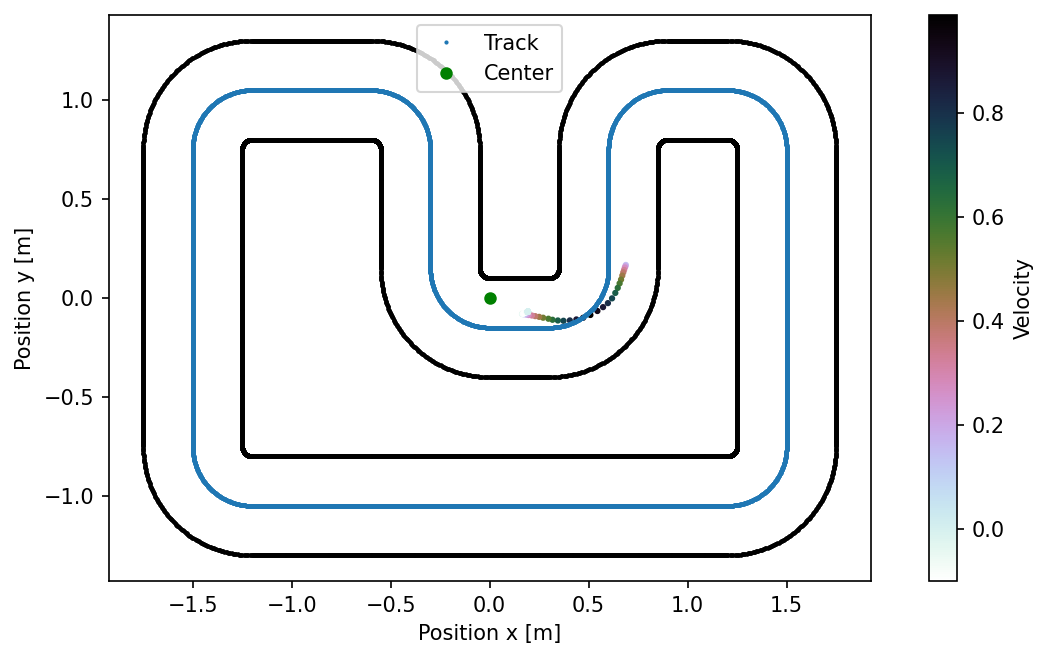

In [21]:
plot_traj(x_sim_test_manual)

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


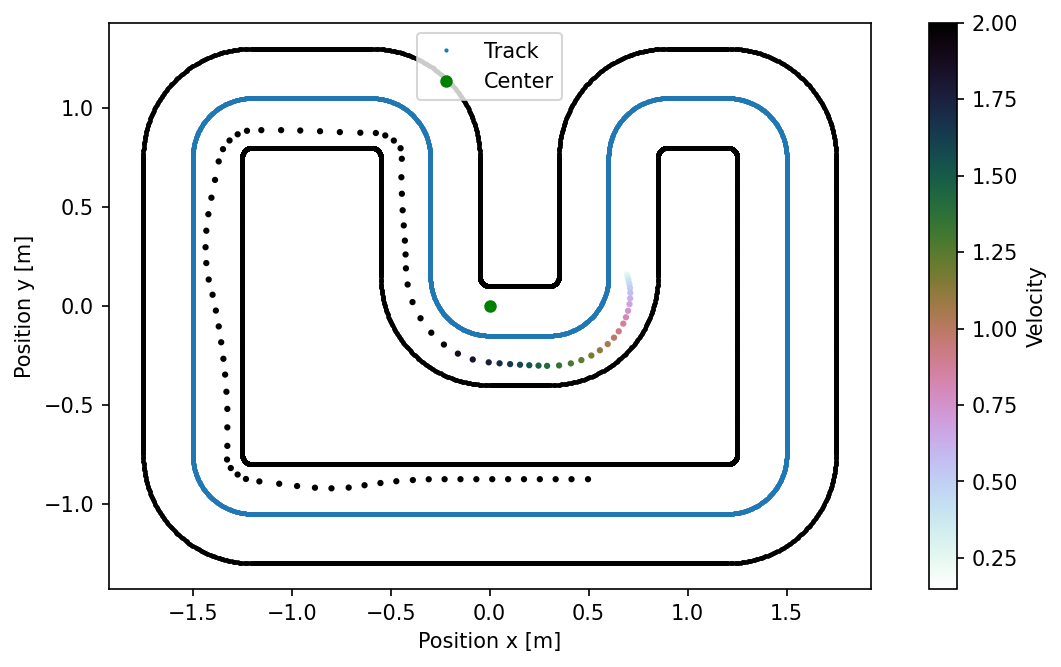

In [22]:
plot_traj(x_sim_test)

In [ ]:
# Initially solve for 
x0 = torch.tensor([0.0, 0.1, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
u0 = torch.tensor([0.0, 0.0])
x_star, u_star = solve_casadi(
            Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
            x0.detach().numpy(),dx,du,control)

num_patches = 10 
BS_init = 4
BS_val = 20

for patch in range(num_patches):
    for it in range(50):
        
        # update batch size such that data points from a later patch have the same weighting as from an earlier
        BS = BS*(patch+1)
        
        u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, BS, 1)#.to(dev)
        u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, BS, 1)#.to(dev)
        u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, BS, 1)#.to(device)

        #x0 = sample_init(BS, true_dx)
        x0 = sample_init_traj(BS, true_dx, x_star, num_patches, patch+1)
        x0_t = sample_init(BS, true_dx)
        
        x0 =x0.float()
        print(x0.size())
        print(x0_t.size())
        curv = get_curve_hor_from_x(x0, track_coord, mpc_H)
        inp = torch.hstack((x0[:,1:4], curv))
        q_p_pred = model(inp)

        q, p = q_and_p(mpc_T, q_p_pred, Q_manual, p_manual)
        Q = torch.diag_embed(q, offset=0, dim1=-2, dim2=-1)
    
        pred_x, pred_u, pred_objs = mpc.MPC(
                    true_dx.n_state, true_dx.n_ctrl, mpc_T,
                    u_lower=u_lower, u_upper=u_upper, u_init=u_init,
                    lqr_iter=lqr_iter,
                    verbose=0,
                    exit_unconverged=False,
                    detach_unconverged=False,
                    linesearch_decay=.8,
                    max_linesearch_iter=4,
                    grad_method=grad_method,
                    eps=eps,
                    n_batch=None,
                )(x0, QuadCost(Q, p), true_dx)
    
        # It would be good if we could solve with casadi in batches
        x_manual = np.zeros((mpc_T, BS, 6))
        for bb in range(BS):
            x_star, u_star = solve_casadi(
                Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
                x0[bb].detach().numpy(),dx,du,control)
            x_manual[:, bb] = x_star
    
        progress = (pred_x[-1,:,5]- torch.tensor(x_manual[-1,:,5]))
        loss = -progress.mean() \
        + true_dx.penalty_d(pred_x[:,:,1]).sum(0).mean() \
        + true_dx.penalty_v(pred_x[:,:,3]).sum(0).mean()
      
        opt.zero_grad()
        loss.backward()
        opt.step()  
    
        # V A L I D A T I O N   (only casadi) 
        with torch.no_grad():
        
            # This sampling should bring always the same set of initial states
            x0_val = sample_init(BS_val, true_dx, sn=0)
        
            # It would be good if we could solve with casadi in batches
            # instead of going through the for loop
            x_pred_casadi = np.zeros((mpc_T, BS_val, 6))
            for bb in range(BS):
                q_val = q[:,bb,idx_to_casadi].detach().numpy().T
                p_val = p[:,bb,idx_to_casadi].detach().numpy().T
                x_val, u_val = solve_casadi(q_val, p_val,
                    x0_val[bb].detach().numpy(),dx,du,control)
                x_pred_casadi[:,bb] = x_val
            
            x_manual = np.zeros((mpc_T, BS_val, 6))
            for bb in range(BS):
                x_star, u_star = solve_casadi(
                    Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
                    x0_val[bb].detach().numpy(),dx,du,control)
                x_manual[:, bb] = x_star

            progress_val = x_pred_casadi[-1,:,5] - x_manual[-1,:,5]
    
        #print(round(progress.mean().item(), 3))    
        #print(q_p_pred.mean(0).mean(0))
    
        print(f'{it}: Progress: ', round(progress_val.mean(), 3))

In [ ]:
for it in range(100):

    x0 = sample_init(BS, true_dx)
    curv = get_curve_hor_from_x(x0, track_coord, mpc_H)
    inp = torch.hstack((x0[:,1:4], curv))
    q_p_pred = model(inp)

    q, p = q_and_p(mpc_T, q_p_pred, Q_manual, p_manual)
    Q = torch.diag_embed(q, offset=0, dim1=-2, dim2=-1)
    
    x0_diff = x0.clone()
    
    progress_pred = torch.tensor(0.)
    penalty_pred_d = torch.tensor(0.)
    penalty_pred_v = torch.tensor(0.)
    for sim in range(0, mpc_H//mpc_T):
        
        pred_x, pred_u, pred_objs = mpc.MPC(
                    true_dx.n_state, true_dx.n_ctrl, mpc_T,
                    u_lower=u_lower, u_upper=u_upper, u_init=u_init,
                    lqr_iter=lqr_iter,
                    verbose=0,
                    exit_unconverged=False,
                    detach_unconverged=False,
                    linesearch_decay=.8,
                    max_linesearch_iter=4,
                    grad_method=grad_method,
                    eps=eps,
                    n_batch=None,
                )(x0_diff, QuadCost(Q, p), true_dx)
        
        x0_diff = pred_x[-1].clone()
        x0_diff[:,4] = x0_diff[:,0]
        x0_diff[:,5] = 0.
        
        progress_pred = progress_pred + pred_x[-1,:,5]
        penalty_pred_d = penalty_pred_d + pred_x[:,:,1]
        penalty_pred_v = penalty_pred_v + pred_x[:,:,3]
        #import pdb
        #pdb.set_trace()
        
    
    # It would be good if we could solve with casadi in batches
    x_manual = np.zeros((mpc_T, BS, 6))
    for bb in range(BS):
        x_star, u_star = solve_casadi(
            Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
            x0[bb].detach().numpy(),dx,du,control)
        x_manual[:, bb] = x_star
    
    progress = (progress_pred - torch.tensor(x_manual[-1,:,5]))
    loss = -progress.mean() \
    + true_dx.penalty_d(penalty_pred_d).sum(0).mean() \
    + true_dx.penalty_v(penalty_pred_v).sum(0).mean()
      
    opt.zero_grad()
    loss.backward()
    opt.step()  
    
    
    if it%5==0:
    # V A L I D A T I O N   (only casadi) 
        with torch.no_grad():

            BS_val = 32

            # This sampling should bring always the same set of initial states
            x0_val = sample_init(BS_val, true_dx, sn=0).numpy()

            x0_val_pred = x0_val[:,:6]
            x0_val_manual = x0_val[:,:6]

            progress_val_pred = 0.
            progress_val_manual = 0.

            for sim in range(mpc_H//mpc_T):

                x0_val_pred_torch = torch.tensor(x0_val_pred, dtype=torch.float32)
                curv_val = get_curve_hor_from_x(x0_val_pred_torch, track_coord, mpc_H)
                inp_val = torch.hstack((x0_val_pred_torch[:,1:4], curv_val))
                q_p_pred_val = model(inp_val)
                q_val, p_val = q_and_p(mpc_T, q_p_pred_val, Q_manual, p_manual)

                # It would be good if we could solve with casadi in batches
                # instead of going through the for loop
                x_pred_val = np.zeros((mpc_T, BS_val, 6))
                for bb in range(BS_val):

                    q_val_ = q_val[:,bb,idx_to_casadi].detach().numpy().T
                    p_val_ = p_val[:,bb,idx_to_casadi].detach().numpy().T
                    x_val, u_val = solve_casadi(q_val_, p_val_,
                        x0_val_pred[bb],dx,du,control)
                    x_pred_val[:,bb] = x_val

                x_manual = np.zeros((mpc_T, BS_val, 6))
                for bb in range(BS_val):
                    x_star, u_star = solve_casadi(
                        Q_manual[:,idx_to_casadi].T, p_manual[:,idx_to_casadi].T,
                        x0_val_manual[bb],dx,du,control)
                    x_manual[:, bb] = x_star

                progress_val_pred = progress_val_pred + x_pred_val[-1,:,5]
                progress_val_manual = progress_val_manual + x_manual[-1,:,5]
                
                x0_val_pred = x_pred_val[-1]
                x0_val_manual = x_manual[-1]
                
                x0_val_pred[:,4] = x0_val_pred[:,0]
                x0_val_manual[:,4] = x0_val_manual[:,0]
                
                x0_val_pred[:,5] = 0.
                x0_val_manual[:,5] = 0.            

            progress_val = progress_val_pred - progress_val_manual

        #print(round(progress.mean().item(), 3))    
        #print(q_p_pred.mean(0).mean(0))

        print(f'{it}: Progress: ', round(progress_val.mean(), 3))